In [2]:
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt
from qutip.ipynbtools import version_table
from tqdm.notebook import tqdm

resol = 200
pi = np.pi
version_table()

Software,Version
QuTiP,5.1.1
Numpy,1.26.2
SciPy,1.11.3
matplotlib,3.7.3
Number of CPUs,11
BLAS Info,Generic
IPython,8.17.2
Python,"3.12.0 (v3.12.0:0fb18b02c8, Oct 2 2023, 09:45:56) [Clang 13.0.0 (clang-1300.0.29.30)]"
OS,posix [darwin]
Cython,3.0.11


In [3]:
#space discretization
L = 6*pi
N = 64 #number of sites on the lattice
delta_L = L/N
position_lattice_list = np.linspace(-L/2, L/2, N)

#photon field
n_modes = 50 #UV cut-off
omega_tab = np.array([2*pi*n/L for n in range(n_modes)]) #tab of frequencies (with engough points to get omega_0)
k_tab = np.copy(omega_tab)

#Jaynes-Cummings parameter g_0 and number of atoms
g_0 = 2*1j
n_A = 1

#fix the energies and the initial wave packet
omega_0 = 13
omega_A = 0.5
bandwith = 2*pi*np.abs(g_0)**2*omega_A
sigma = L/16

print("Bandwith: ", bandwith)
print("Omega ~ ", 1/sigma)

#tab with the coupling parameters
use_WW_approx = False
g_tab = np.zeros((n_modes, n_A), dtype=complex)
for i in range(n_modes):
    for j in range(n_A):
        if use_WW_approx:
            g_tab[i, j] = g_0*np.sqrt(omega_A)
        else:
            g_tab[i, j] = g_0*np.sqrt(omega_tab[i]) #in my case, g is independant of the atom index


#dimension of the subspace restricted to 2 photons
dim_subspace = n_modes * (2*n_modes + 1) + 2*n_modes*n_A + n_A*(n_A-1)//2
print("Max momentum: ", k_tab[-1])
print("Dimension of the subspace: ", dim_subspace)

Bandwith:  12.566370614359172
Omega ~  0.8488263631567752
Max momentum:  16.333333333333332
Dimension of the subspace:  5150


Evolution in the interaction picture

In [4]:
def runge_kutta_scheme(H, init_state, times, progress_bar=True):
    """
    Runge-Kutta scheme for the time evolution of a quantum state

    ---Parameters---
    H : function
        H(t) return the Hamiltonian (qObj) at time t
    init_state : qObj
        initial state
    times : array
        array of times

    ---Returns---
    state_list : list
        list of states at each time
    """

    state_list = [init_state]
    dt = times[1] - times[0]

    for i in tqdm(range(1, len(times)), disable=not progress_bar):

        t = times[i]
        H_0 = H(t)
        H_1 = H(t + dt/2)
        H_2 = H(t + dt)

        k1 = -1j*dt*H_0*state_list[-1]
        k2 = -1j*dt*H_1*(state_list[-1] + k1/2)
        k3 = -1j*dt*H_1*(state_list[-1] + k2/2)
        k4 = -1j*dt*H_2*(state_list[-1] + k3)

        new_state = state_list[-1] + (k1 + 2*k2 + 2*k3 + k4)/6
        #enforce normalization
        new_state = new_state.unit()
        state_list.append(new_state)
       
    return state_list

<h1> Definition of the Hamiltonian </h1>

The Hamiltonian is defined by:
 
$$ H = \sum_{k,j} \left\{g(k,j) e^{i(\omega_k - \omega_A)t} (a_k^{\dagger} + b_k^{\dagger}) \sigma_j^- + g(k,j)^* e^{-i(\omega_k - \omega_A)t} (a_k + b_k) \sigma_j^+ \right\} $$

The operator $a$ labels the horizontal modes and $b$ the orthogonal modes. Under my hypothesis, $g(k,j) = i g$ for all $k, j$. Let me define this Hamiltonian

[TO BE CHECKED]

In [5]:
def H(t):
    H_matrix = np.zeros((dim_subspace, dim_subspace), dtype=complex)

    ## Off diagonal elements
        
    #|2,0,0> <-> |1,0,1>
    dummy_index_0 = 0
    for i in range(n_modes):
        for j in range(i, n_modes):
            dummy_index_1 = n_modes*(2*n_modes + 1)
            for k in range(n_modes):
                for l in range(n_A):
                    if k == i:
                        if i == j:
                            H_matrix[dummy_index_1, dummy_index_0] = np.sqrt(2)*np.conjugate(g_tab[j,l])* np.exp(-1j*(omega_tab[j] - omega_A)*t)
                            H_matrix[dummy_index_0, dummy_index_1] = np.conjugate(H_matrix[dummy_index_1, dummy_index_0])
                        else:
                            H_matrix[dummy_index_1, dummy_index_0] = np.sqrt(2)*np.conjugate(g_tab[j,l])* np.exp(-1j*(omega_tab[j] - omega_A)*t)
                            H_matrix[dummy_index_0, dummy_index_1] = np.conjugate(H_matrix[dummy_index_1, dummy_index_0])
                    if k == j:
                        if i == j:
                            H_matrix[dummy_index_1, dummy_index_0] = np.sqrt(2)*np.conjugate(g_tab[i,l])* np.exp(-1j*(omega_tab[i] - omega_A)*t)
                            H_matrix[dummy_index_0, dummy_index_1] = np.conjugate(H_matrix[dummy_index_1, dummy_index_0])
                        else:
                            H_matrix[dummy_index_1, dummy_index_0] = np.sqrt(2)*np.conjugate(g_tab[i,l])* np.exp(-1j*(omega_tab[i] - omega_A)*t)
                            H_matrix[dummy_index_0, dummy_index_1] = np.conjugate(H_matrix[dummy_index_1, dummy_index_0])
                    dummy_index_1 += 1
            dummy_index_0 += 1

    #|0,2,0> <-> |0,1,1>
    dummy_index_0 = n_modes*(n_modes + 1)//2
    for i in range(n_modes):
        for j in range(i, n_modes):
            dummy_index_1 = n_modes*(2*n_modes + 1) + n_modes*n_A
            for k in range(n_modes):
                for l in range(n_A):
                    if k == i:
                        if i == j:
                            H_matrix[dummy_index_1, dummy_index_0] = np.sqrt(2)*np.conjugate(g_tab[j,l])* np.exp(-1j*(omega_tab[j] - omega_A)*t)
                            H_matrix[dummy_index_0, dummy_index_1] = np.conjugate(H_matrix[dummy_index_1, dummy_index_0])
                        else:
                            H_matrix[dummy_index_1, dummy_index_0] = np.sqrt(2)*np.conjugate(g_tab[j,l])* np.exp(-1j*(omega_tab[j] - omega_A)*t)
                            H_matrix[dummy_index_0, dummy_index_1] = np.conjugate(H_matrix[dummy_index_1, dummy_index_0])
                    if k == j:
                        if i == j:
                            H_matrix[dummy_index_1, dummy_index_0] = np.sqrt(2)*np.conjugate(g_tab[i,l])* np.exp(-1j*(omega_tab[i] - omega_A)*t)
                            H_matrix[dummy_index_0, dummy_index_1] = np.conjugate(H_matrix[dummy_index_1, dummy_index_0])
                        else:
                            H_matrix[dummy_index_1, dummy_index_0] = np.sqrt(2)*np.conjugate(g_tab[i,l])* np.exp(-1j*(omega_tab[i] - omega_A)*t)
                            H_matrix[dummy_index_0, dummy_index_1] = np.conjugate(H_matrix[dummy_index_1, dummy_index_0])
                    dummy_index_1 += 1
            dummy_index_0 += 1

    #|1,1,0> <-> |1,0,1>
    dummy_index_0 = n_modes*(n_modes + 1)
    for i in range(n_modes):
       for j in range(n_modes):
            dummy_index_1 = n_modes*(2*n_modes + 1) 
            for k in range(n_modes):
                for l in range(n_A):
                    if k == i:
                        H_matrix[dummy_index_1, dummy_index_0] = np.conjugate(g_tab[j,l]) * np.exp(-1j*(omega_tab[j] - omega_A)*t)
                        H_matrix[dummy_index_0, dummy_index_1] = np.conjugate(H_matrix[dummy_index_1, dummy_index_0])
                    if k == j:
                        H_matrix[dummy_index_1, dummy_index_0] = np.conjugate(g_tab[i,l]) * np.exp(-1j*(omega_tab[i] - omega_A)*t)
                        H_matrix[dummy_index_0, dummy_index_1] = np.conjugate(H_matrix[dummy_index_1, dummy_index_0])
                    
                    dummy_index_1 += 1
            dummy_index_0 += 1
    
    #|1,1,0> <-> |0,1,1>
    dummy_index_0 = n_modes*(n_modes + 1)
    for i in range(n_modes):
       for j in range(n_modes):
            dummy_index_1 = n_modes*(2*n_modes + 1) + n_modes*n_A
            for k in range(n_modes):
                for l in range(n_A):
                    if k == i:
                        H_matrix[dummy_index_1, dummy_index_0] = np.conjugate(g_tab[j,l]) * np.exp(-1j*(omega_tab[j] - omega_A)*t)
                        H_matrix[dummy_index_0, dummy_index_1] = np.conjugate(H_matrix[dummy_index_1, dummy_index_0])
                    if k == j:
                        H_matrix[dummy_index_1, dummy_index_0] = np.conjugate(g_tab[i,l]) * np.exp(-1j*(omega_tab[i] - omega_A)*t)
                        H_matrix[dummy_index_0, dummy_index_1] = np.conjugate(H_matrix[dummy_index_1, dummy_index_0])
                    
                    dummy_index_1 += 1
            dummy_index_0 += 1


    if n_A > 1:
        #|1,0,1> <-> |0,0,2>
        dummy_index_0 = n_modes*(2*n_modes + 1)
        for i in range(n_modes):
            for j in range(n_A):
                dummy_index_1 = n_modes*(2*n_modes + 1) + 2*n_modes*n_A
                for k in range(n_A):
                    for l in range(k+1, n_A):
                        if k == j:
                            H_matrix[dummy_index_1, dummy_index_0] = np.conjugate(g_tab[i,l]) * np.exp(-1j*(omega_tab[i]-omega_A)*t)
                            H_matrix[dummy_index_0, dummy_index_1] = np.conjugate(H_matrix[dummy_index_1, dummy_index_0])
                        if l == j:
                            H_matrix[dummy_index_1, dummy_index_0] = np.conjugate(g_tab[i,k]) * np.exp(-1j*(omega_tab[i]-omega_A)*t)
                            H_matrix[dummy_index_0, dummy_index_1] = np.conjugate(H_matrix[dummy_index_1, dummy_index_0])
                        dummy_index_1 += 1
                dummy_index_0 += 1
            
        #|0,1,1> <-> |0,0,2>
        dummy_index_0 = n_modes*(2*n_modes + 1) + n_modes*n_A
        for i in range(n_modes):
            for j in range(n_A):
                dummy_index_1 = n_modes*(2*n_modes + 1) + 2*n_modes*n_A
                for k in range(n_A):
                    for l in range(k+1, n_A):
                        if k == j:
                            H_matrix[dummy_index_1, dummy_index_0] = np.conjugate(g_tab[i,l]) * np.exp(-1j*(omega_tab[i]-omega_A)*t)
                            H_matrix[dummy_index_0, dummy_index_1] = np.conjugate(H_matrix[dummy_index_1, dummy_index_0])
                        if l == j:
                            H_matrix[dummy_index_1, dummy_index_0] = np.conjugate(g_tab[i,k]) * np.exp(-1j*(omega_tab[i]-omega_A)*t)
                            H_matrix[dummy_index_0, dummy_index_1] = np.conjugate(H_matrix[dummy_index_1, dummy_index_0])
                        dummy_index_1 += 1
                dummy_index_0 += 1


    H_qobj = qt.Qobj(H_matrix)

    if not H_qobj.isherm:
        print("Warning : Hamiltonian is not hermitian")

    return H_qobj

I also define the operators $N_a(k) = a_k^{\dagger} a_k$, $N_b(k) = b_k^{\dagger} b_k$ and $N_j = (1+\sigma_j^z)/2$. Recall that I work with the basis:
$$ \left\{ \ket{2_a, 0_b, 0}, \ket{0_a, 2_b, 0}, \ket{1_a, 1_b, 0}, \ket{1_a, 0, 1}, \ket{0, 1_b, 1}, \ket{0_a, 0_b, 2}\right \}$$

In [6]:
occupation_a_list = []
occupation_b_list = []
sigma_z_list = []

#for horizontal modes
for n in range(n_modes):
    occupation_matrix = np.zeros((dim_subspace, dim_subspace), dtype=complex)
    #|2,0,0> states
    dummy_index = 0
    for i in range(n_modes):
        for j in range(i, n_modes):
            if i == n or j == n:
                if i == j:
                    occupation_matrix[dummy_index, dummy_index] = 2
                else:
                    occupation_matrix[dummy_index, dummy_index] = 1
            dummy_index += 1
    
    #|1,1,0> states
    dummy_index = n_modes*(n_modes + 1)
    for i in range(n_modes):
        for j in range(n_modes):
            if i == n:
                occupation_matrix[dummy_index, dummy_index] = 1
            dummy_index += 1
            

    #|1,0,1> states
    dummy_index = n_modes*(2*n_modes + 1)
    for i in range(n_modes):
        for j in range(n_A):
            if i == n:
                occupation_matrix[dummy_index, dummy_index] = 1
            dummy_index += 1
    
    occupation_operator = qt.Qobj(occupation_matrix)
    occupation_a_list.append(occupation_operator)

#same for vertical modes
for n in range(n_modes):
    occupation_matrix = np.zeros((dim_subspace, dim_subspace), dtype=complex)
    #|0,2,0> states
    dummy_index = n_modes*(n_modes + 1)//2
    for i in range(n_modes):
        for j in range(i, n_modes):
            if i == n or j == n:
                if i == j:
                    occupation_matrix[dummy_index, dummy_index] = 2
                else:
                    occupation_matrix[dummy_index, dummy_index] = 1
            dummy_index += 1
    
    #|1,1,0> states
    dummy_index = n_modes*(n_modes + 1)
    for i in range(n_modes):
        for j in range(n_modes):
            if j == n:
                occupation_matrix[dummy_index, dummy_index] = 1
            dummy_index += 1
            

    #|0,1,1> states
    dummy_index = n_modes*(2*n_modes + 1) + n_modes*n_A
    for i in range(n_modes):
        for j in range(n_A):
            if i == n:
                occupation_matrix[dummy_index, dummy_index] = 1
            dummy_index += 1
    
    occupation_operator = qt.Qobj(occupation_matrix)
    occupation_b_list.append(occupation_operator)

#for sigma_z
for x in range(n_A):
    sigma_matrix = np.zeros((dim_subspace, dim_subspace), dtype=complex)
    #|1,0,1> states 
    dummy_index = n_modes*(2*n_modes + 1)
    for i in range(n_modes):
        for j in range(n_A):
            if j == x:
                sigma_matrix[dummy_index, dummy_index] = 1
            dummy_index += 1
    
    #|0,1,1> states
    dummy_index = n_modes*(2*n_modes + 1) + n_modes*n_A
    for i in range(n_modes):
        for j in range(n_A):
            if j == x:
                sigma_matrix[dummy_index, dummy_index] = 1
            dummy_index += 1
    
    #|0,0,2> states
    dummy_index = n_modes*(2*n_modes + 1) + 2*n_modes*n_A
    for i in range(n_A):
        for j in range(i+1, n_A):
            if i == x or j == x:
                sigma_matrix[dummy_index, dummy_index] = 1
            dummy_index += 1

    sigma_operator = qt.Qobj(sigma_matrix)
    sigma_z_list.append(sigma_operator)


<h1> Time evolution : first test (skip if one more than one mode per direction)</h1>

First sanity check : I keep only one mode per direction, I am supposed to recover the result of the file only_two_modes.ipynb

In [251]:
init_state = qt.basis(dim_subspace, 0)
dt = 0.001
T = 4*pi
times = np.linspace(0, T, int(T/dt))
state_list = runge_kutta_scheme(H, init_state, times)

  0%|          | 0/12565 [00:00<?, ?it/s]

Try to recover the mean values of the occupation numbers

In [252]:
nb_pts = len(times)
mean_a_list = np.zeros((n_modes, nb_pts))
mean_b_list = np.zeros((n_modes, nb_pts))

for i in range(nb_pts):
    state = state_list[i]
    for n in range(n_modes):
        mean_a_list[n, i] = qt.expect(occupation_a_list[n], state)
        mean_b_list[n, i] = qt.expect(occupation_b_list[n], state)

And plot the results

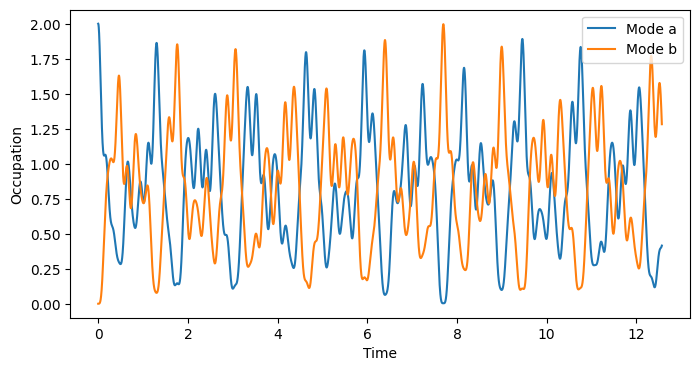

In [253]:
index_mode = 0
fig, ax = plt.subplots(1, 1, figsize=(8,4))
ax.plot(times, mean_a_list[index_mode], label="Mode a")
ax.plot(times, mean_b_list[index_mode], label="Mode b")
ax.set_xlabel("Time")
ax.set_ylabel("Occupation")
ax.legend()

plt.show()

<h1> Coincidence evolution </h1>

First, define the initial state

In [7]:
k_tab = np.copy(omega_tab)
k_bar = k_tab[np.argmin(np.abs(k_tab - omega_0))]
r_bar_a = -L/4
delta_r = 0
r_bar_b = r_bar_a + delta_r
sigma = L/16

c_list = []

init_state = 0
for i in range(n_modes**2):
    k_a = k_tab[int(i//n_modes)]
    k_b = k_tab[int(i%n_modes)]

    c_a = np.exp(-0.5*sigma**2*(k_a - k_bar)**2 -1j * k_a * r_bar_a)
    c_b = np.exp(-0.5*sigma**2*(k_b - k_bar)**2 -1j * k_b * r_bar_b)

    if i//n_modes == i/n_modes:
        c_list.append(c_a)

    init_state += c_a * c_b * qt.basis(dim_subspace, n_modes*(n_modes+1) + i)

init_state = init_state.unit()

Define the total occupation operators : 
$$N_a = \sum_k N_a(k) \,\, , \,\, N_b = \sum_k N_b(k) $$

In [8]:
N_a = 0
N_b = 0
for i in range(n_modes):
    N_a += occupation_a_list[i]
    N_b += occupation_b_list[i]

Now conduct the time evolution

In [9]:
dt = 0.01
T = L/2
times = np.linspace(0, T, int(T/dt))
print("Dimension of the subspace : ", dim_subspace)
state_list = runge_kutta_scheme(H, init_state, times)

Dimension of the subspace :  5150


  0%|          | 0/941 [00:00<?, ?it/s]

Store the results and plot

In [10]:
nb_pts = len(times)
coincidence_tab = np.zeros(nb_pts)
for i in tqdm(range(nb_pts)):
    state = state_list[i]
    coincidence_tab[i] = np.real(state.dag() * N_a * N_b * state)

  0%|          | 0/942 [00:00<?, ?it/s]

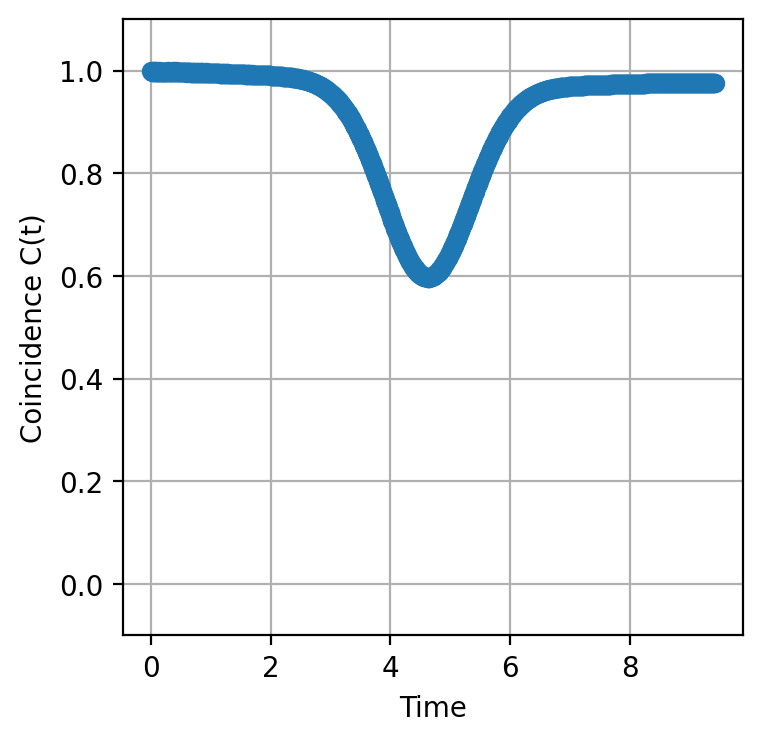

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(4,4), dpi=200)
ax.plot(times, coincidence_tab, marker='o')
ax.set_xlabel("Time")
ax.set_ylabel("Coincidence C(t)")
ax.grid()
ax.set_ylim(-0.1, 1.1)

plt.show()


<h1> HOM effect </h1>

Define the initial state

In [16]:
k_tab = np.copy(omega_tab)
k_bar = k_tab[np.argmin(np.abs(k_tab - omega_0))]
r_bar_a = -L/4
delta_r = 0
r_bar_b = r_bar_a + delta_r
sigma = 1/(0.001 * bandwith) #monocromatic limit

c_list = []

init_state = 0
for i in range(n_modes**2):
    k_a = k_tab[int(i//n_modes)]
    k_b = k_tab[int(i%n_modes)]
        
    c_a = np.exp(-0.5*sigma**2*(k_a - k_bar)**2 -1j * k_a * r_bar_a)
    c_b = np.exp(-0.5*sigma**2*(k_b - k_bar)**2 -1j * k_b * r_bar_b)

    if i//n_modes == i/n_modes:
        c_list.append(c_a)

    init_state += c_a * c_b * qt.basis(dim_subspace, n_modes*(n_modes+1) + i)

init_state = init_state.unit()

Show the coefficients probability density for each wave packet

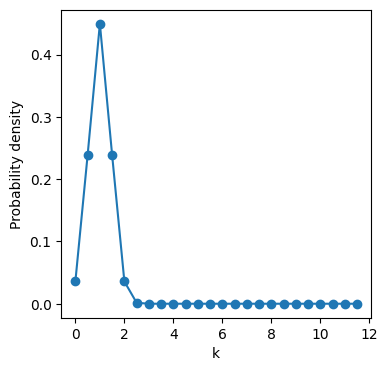

In [17]:
c_list = np.array(c_list, dtype=complex)
proba_density = np.abs(c_list)**2 
proba_density = proba_density/np.sum(proba_density)

fig, ax = plt.subplots(1, 1, figsize=(4,4))
ax.plot(k_tab, proba_density, marker="o")
ax.set_xlabel("k")
ax.set_ylabel("Probability density")
plt.show()

Now, I evolve the state and compute the overlap with the initial state (equivalent to Soeda's paper in interaction picture)

In [18]:
dt = 0.001
T = L
times = np.linspace(0, T, int(T/dt))
print("Dimension of the subspace : ", dim_subspace)
state_list = runge_kutta_scheme(H, init_state, times)
final_overlap = qt.fidelity(state_list[-1], state_list[0])
print("Final overlap : ", final_overlap)

Dimension of the subspace :  1224


  0%|          | 0/12565 [00:00<?, ?it/s]

Final overlap :  0.3681208902749812


Varying $\Delta r$

In [254]:
delta_r_tab = np.array([-L/6, -L/8, 0, L/6, L/8])
final_overlap_tab = np.zeros(len(delta_r_tab))
nb_pts_r = len(delta_r_tab)

dt = 0.001
T = L
times = np.linspace(0, T, int(T/dt))

for x in range(nb_pts_r):
    k_tab = np.copy(omega_tab)
    k_bar = k_tab[np.argmin(np.abs(k_tab - omega_0))]
    r_bar_a = -L/4
    delta_r = delta_r_tab[x]
    r_bar_b = r_bar_a + delta_r
    sigma = 1/(0.001 * bandwith) #monocromatic limit

    init_state = 0
    for i in range(n_modes**2):
        k_a = k_tab[int(i//n_modes)]
        k_b = k_tab[int(i%n_modes)]
            
        c_a = np.exp(-0.5*sigma**2*(k_a - k_bar)**2 -1j * k_a * r_bar_a)
        c_b = np.exp(-0.5*sigma**2*(k_b - k_bar)**2 -1j * k_b * r_bar_b)

        init_state += c_a * c_b * qt.basis(dim_subspace, n_modes*(n_modes+1) + i)

    init_state = init_state.unit()

    print("Computing for delta_r = ", delta_r)
    state_list = runge_kutta_scheme(H, init_state, times)
    final_overlap = qt.fidelity(state_list[-1], state_list[0])
    final_overlap_tab[x] = final_overlap


Computing for delta_r =  -2.0943951023931953


  0%|          | 0/12565 [00:00<?, ?it/s]

Computing for delta_r =  -1.5707963267948966


  0%|          | 0/12565 [00:00<?, ?it/s]

Computing for delta_r =  0.0


  0%|          | 0/12565 [00:00<?, ?it/s]

Computing for delta_r =  2.0943951023931953


  0%|          | 0/12565 [00:00<?, ?it/s]

Computing for delta_r =  1.5707963267948966


  0%|          | 0/12565 [00:00<?, ?it/s]

Theoretical curve

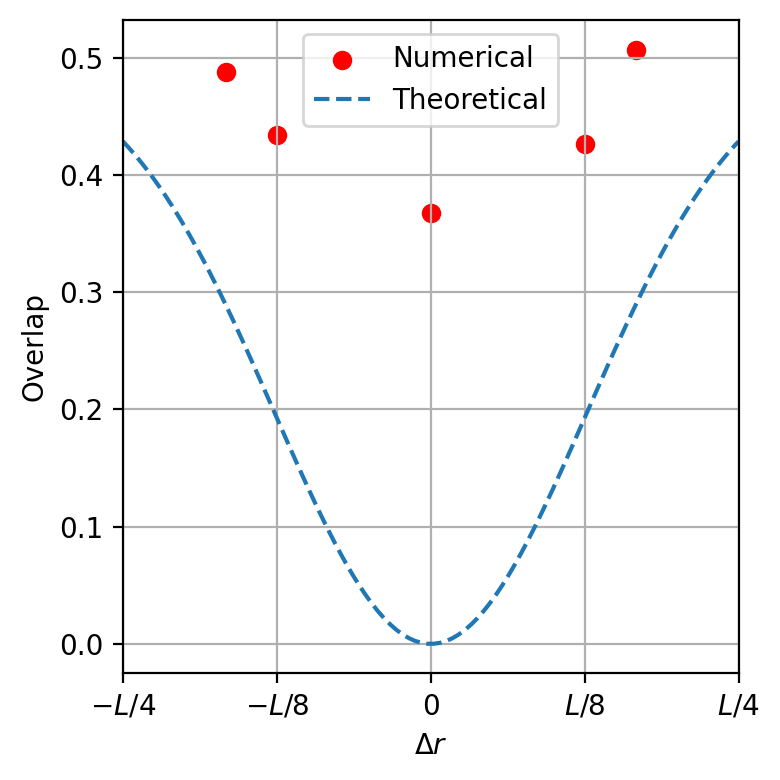

In [256]:
#plot the theoretical curve
delta_r_theory = np.linspace(-L/4, L/4, 100)
theory_curve = 0.5*(1-np.exp(-0.5*delta_r_theory**2/sigma**2))

fig, ax = plt.subplots(1, 1, figsize=(4,4), dpi=resol)
ax.scatter(delta_r_tab, final_overlap_tab, marker='o', label='Numerical', color='red')
ax.plot(delta_r_theory, theory_curve, linestyle='--', label='Theoretical')

#put labels in L units
ax.set_xlim(-L/4, L/4)
ax.set_xticks([-L/4, -L/8, 0, L/8, L/4])
ax.set_xticklabels(['$-L/4$', '$-L/8$', '0', '$L/8$', '$L/4$'])

ax.set_xlabel('$\\Delta r$')
ax.set_ylabel('Overlap')
ax.grid()
ax.legend()

plt.tight_layout()

#save the figure
#plt.savefig("figures/HOM_effect_L16_g09.pdf")
plt.show()